# <center> Bread Proofing & Convolutional Neural Networks </center>

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchinfo import summary
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2
from architecture import ConvolutionalNN, EarlyStopper, ImageDataset

For experiments, we are going to track the following hyperparameters: 

In [3]:
batch_size = 2**8
epochs = 32
learning_rate = 1e-3
is_grayscale = False
dim = 2**6  # w, h of images

In [4]:
policies = [
    v2.AutoAugmentPolicy.CIFAR10,
    v2.AutoAugmentPolicy.IMAGENET,
    v2.AutoAugmentPolicy.SVHN
]
images_per_policy = 4

train_ds = ImageDataset(dim, split="train", is_grayscale=is_grayscale, augmented=True, policies=policies, images_per_policy=images_per_policy)
valid_ds = ImageDataset(dim, split="valid", is_grayscale=is_grayscale)
test_ds = ImageDataset(dim, split="test", is_grayscale=is_grayscale)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = ConvolutionalNN().to(device)
num_channels = 1 if is_grayscale else 3
print(summary(model, input_size=(batch_size, num_channels, dim, dim)))

Using cpu device
Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionalNN                          [256, 3]                  --
├─Sequential: 1-1                        [256, 3]                  --
│    └─Conv2d: 2-1                       [256, 48, 32, 32]         3,648
│    └─ReLU: 2-2                         [256, 48, 32, 32]         --
│    └─BatchNorm2d: 2-3                  [256, 48, 32, 32]         96
│    └─MaxPool2d: 2-4                    [256, 48, 16, 16]         --
│    └─Conv2d: 2-5                       [256, 96, 16, 16]         41,568
│    └─ReLU: 2-6                         [256, 96, 16, 16]         --
│    └─BatchNorm2d: 2-7                  [256, 96, 16, 16]         192
│    └─MaxPool2d: 2-8                    [256, 96, 8, 8]           --
│    └─Conv2d: 2-9                       [256, 128, 8, 8]          110,720
│    └─ReLU: 2-10                        [256, 128, 8, 8]          --
│    └─BatchNorm2d: 2-11                 [256, 128, 8, 

In [6]:
weight = train_ds.df["label"].value_counts().to_numpy()
weight = torch.from_numpy(train_ds.df.shape[0] / len(weight) / weight).float()

loss_fn = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # OR: SGD
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

early_stopper = EarlyStopper(patience=3, min_delta=0.3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    
    for idx, (X, y) in enumerate(tqdm(dataloader)):
        optimizer.zero_grad()
    
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
            
    scheduler.step()


def test(dataloader, model, loss_fn, split="Validation"):
    model.eval()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct = correct * 100 / size  # percent correct
    return correct, test_loss
    

def main():    
    training_loss = []
    validation_loss = []

    for _ in tqdm(range(epochs), desc="Epochs"):
        train(train_dl, model, loss_fn, optimizer)
        
        ta, tl = test(train_dl, model, loss_fn, split="Train")
        va, vl = test(valid_dl, model, loss_fn)
        training_loss.append(tl); validation_loss.append(vl)
        if early_stopper.early_stop(vl):             
            break
    
    # Plot the training loss alongside the validation loss
    fig, ax = plt.subplots()
    x = np.arange(1, len(training_loss) + 1)  # not epochs, as could have early stop
    ax.plot(x, training_loss, label="Training Loss")
    ax.plot(x, validation_loss, label="Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend()
    
    test(test_dl, model, loss_fn, split="Test")

Epochs:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

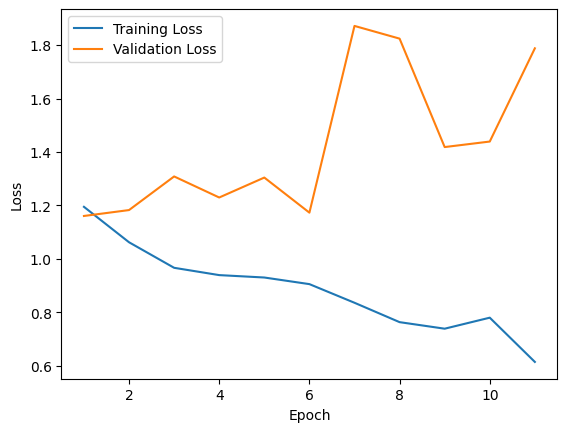

In [8]:
main()

torch.save(model.state_dict(), "./breadrx-cnn.pth")

To visualize how different regions of the input image are affecting the predicted label, we use class activation mapping on the last layer.

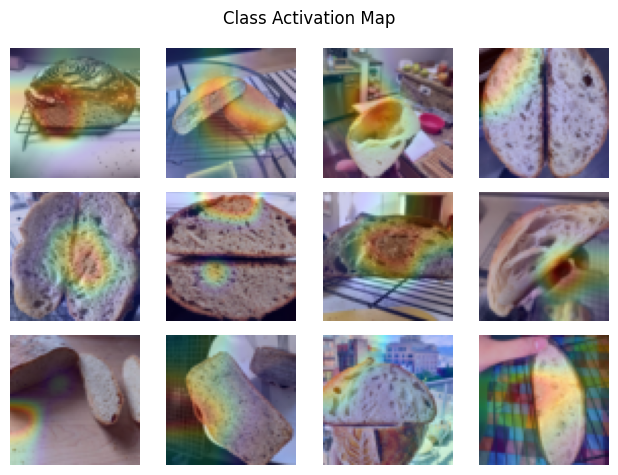

In [9]:
model.eval()

results = []
input_shape = test_dl.dataset[0][0].shape
with SmoothGradCAMpp(model, target_layer="cnn.16", input_shape=input_shape) as cam_extractor:
    for i in range(12):
        im, _ = test_dl.dataset[i]
        out = model(im.unsqueeze(0))
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

        results.append(overlay_mask(
            to_pil_image(im), 
            to_pil_image(activation_map[0].squeeze(0), mode="F"), 
            alpha=0.8
        ))

fig, axs = plt.subplots(3, 4)
for idx, ax in enumerate(axs.flat):
    ax.imshow(results[idx])
    ax.axis("off")
fig.suptitle("Class Activation Map")
plt.tight_layout()
fig.savefig("./cam.png")
plt.show()